In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pycaret.classification import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


In [2]:
def idade_media(df_train: pd.DataFrame, df_test: pd.DataFrame):
    _df_test = pd.DataFrame.copy(df_test)
    _df_train = pd.DataFrame.copy(df_train)

    _df_test['Survived'] = 0

    df = pd.concat([_df_train, _df_test], ignore_index=True)
    df.dropna(subset=['Age'], how='all', inplace=True)
    return df.groupby('Saudacao')['Age'].mean()

def set_idade_media_if_null(row: pd.Series, media):
    result = row['Age']
    if ( np.isnan(row['Age']) ):
        result = media[row['Saudacao']]
    return result

def tipoIdade(x):
    if x < 18:
        return 'Crianca'
    elif x >= 18 and x < 50:
        return 'Adulto'
    else:
        return 'Idoso'

In [3]:
# Load the data
split_train = False
if split_train:
  df = pd.read_csv("train.csv")
  train, test = train_test_split(df, test_size=0.3, random_state=100)
else:
  train = pd.read_csv("train.csv")
  test = pd.read_csv("test.csv")

_train = pd.read_csv("train.csv")
_test = pd.read_csv("test.csv")

In [4]:
train['Cabin'] = train['Cabin'].str[0:1]
train['Cabin'].fillna('C', inplace=True)
test['Cabin'] = test['Cabin'].str[0:1]
test['Cabin'].fillna('C', inplace=True)

train['Tam_Familia'] = train['SibSp'] + train['Parch']
test['Tam_Familia'] = test['SibSp'] + test['Parch']

train['Saudacao'] = train['Name'].str.extract("([A-Za-z]+)\.")
test['Saudacao'] = test['Name'].str.extract("([A-Za-z]+)\.")

_idade_media = idade_media(train, test)
train['Age'] = train.apply(set_idade_media_if_null, axis=1, media=_idade_media)
test['Age'] = test.apply(set_idade_media_if_null, axis=1, media=_idade_media)

# Reduzindo possibilidades para padronizar modelo, pois em teste não há todos os tipos existentes e treino
train['Saudacao']\
  .replace(['Mlle','Mme', 'Ms',  'Dr','Major','Lady','Countess','Jonkheer','Col',  'Rev',  'Capt','Sir','Don'],
           ['Miss','Miss','Miss','Mr','Mr',   'Mrs', 'Mrs',     'Other',   'Other','Other','Mr',  'Mr', 'Mr'], inplace=True)
test['Saudacao']\
  .replace(['Dona','Mlle','Mme', 'Ms',  'Dr','Major','Lady','Countess','Jonkheer','Col',  'Rev',  'Capt','Sir','Don'],
           ['Miss','Miss','Miss','Miss','Mr','Mr',   'Mrs', 'Mrs',     'Other',   'Other','Other','Mr',  'Mr',  'Mr'], inplace=True)

# Classificando idade por Criança, Adulto, Idoso
train['t_idade'] = train['Age'].apply(lambda x: tipoIdade(x))
test['t_idade'] = test['Age'].apply(lambda x: tipoIdade(x))

In [5]:
train_embarked_dummies = pd.get_dummies(train.loc[:,['Embarked']])
train_sex_dummies = pd.get_dummies(train.loc[:,['Sex']])
train_saudacao_dummies = pd.get_dummies(train.loc[:,['Saudacao']])
train_t_idade = pd.get_dummies(train.loc[:,['t_idade']])
train_cabin = pd.get_dummies(train.loc[:,['Cabin']])

test_embarked_dummies = pd.get_dummies(test.loc[:,['Embarked']])
test_sex_dummies = pd.get_dummies(test.loc[:,['Sex']])
test_saudacao_dummies = pd.get_dummies(test.loc[:,['Saudacao']])
test_t_idade = pd.get_dummies(test.loc[:,['t_idade']])
test_cabin = pd.get_dummies(test.loc[:,['Cabin']])

In [6]:
X = pd.concat([train.loc[:,['Survived','Pclass', 'Tam_Familia']], \
                      train_saudacao_dummies, \
                      train_embarked_dummies,\
                      train_sex_dummies,\
                      train_t_idade,\
                      train_cabin
                        ], axis=1)

X

,Survived,Pclass,Tam_Familia,Saudacao_Master,Saudacao_Miss,Saudacao_Mr,Saudacao_Mrs,Saudacao_Other,Embarked_C,Embarked_Q,...,t_idade_Crianca,t_idade_Idoso,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T
0,0,3,1,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,1,1,1,0,0,0,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0
2,1,3,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,1,1,1,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,3,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
887,1,1,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
888,0,3,3,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
889,1,1,0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0


In [7]:
X_test = pd.concat([test.loc[:,['Pclass', 'Tam_Familia']], \
                      test_saudacao_dummies, \
                      test_embarked_dummies,\
                      test_sex_dummies,\
                      test_t_idade,\
                      test_cabin
                        ], axis=1)

X_test['Cabin_T'] = False
X_test

,Pclass,Tam_Familia,Saudacao_Master,Saudacao_Miss,Saudacao_Mr,Saudacao_Mrs,Saudacao_Other,Embarked_C,Embarked_Q,Embarked_S,...,t_idade_Crianca,t_idade_Idoso,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T
0,3,0,0,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,False
1,3,1,0,0,0,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,False
2,2,0,0,0,1,0,0,0,1,0,...,0,1,0,0,1,0,0,0,0,False
3,3,0,0,0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,False
4,3,2,0,0,0,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,3,0,0,0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,False
414,1,0,0,1,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,False
415,3,0,0,0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,False
416,3,0,0,0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,False


In [8]:
setup(data=X, \
      target='Survived', \
      session_id=123, \
      #n_jobs=10, \
      #use_gpu=True
      )

,Description,Value
0,Session id,123
1,Target,Survived
2,Target type,Binary
3,Original data shape,"(891, 24)"
4,Transformed data shape,"(891, 24)"
5,Transformed train set shape,"(623, 24)"
6,Transformed test set shape,"(268, 24)"
7,Numeric features,23
8,Preprocess,True
9,Imputation type,simple


In [9]:
top3 = compare_models(n_select=3)
print(top3)
models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8474,0.8600,0.7194,0.8627,0.7796,0.6653,0.6759,0.0650
gbc,Gradient Boosting Classifier,0.8346,0.8668,0.7069,0.8403,0.7650,0.6393,0.6471,0.0300
catboost,CatBoost Classifier,0.8346,0.8653,0.7152,0.8335,0.7663,0.6400,0.6475,0.5610
rf,Random Forest Classifier,0.8298,0.8519,0.7067,0.8286,0.7589,0.6291,0.6370,0.0500
xgboost,Extreme Gradient Boosting,0.8281,0.8492,0.7025,0.8285,0.7560,0.6253,0.6337,0.0290
knn,K Neighbors Classifier,0.8266,0.8274,0.7069,0.8175,0.7536,0.6219,0.6292,0.0940
lr,Logistic Regression,0.8265,0.8668,0.7612,0.7840,0.7701,0.6309,0.6335,0.1150
et,Extra Trees Classifier,0.8250,0.8287,0.6817,0.8337,0.7466,0.6157,0.6254,0.0460
ada,Ada Boost Classifier,0.8234,0.8658,0.7741,0.7671,0.7689,0.6262,0.6281,0.0280
ridge,Ridge Classifier,0.8232,0.0000,0.7486,0.7817,0.7634,0.6225,0.6242,0.0220


Processing:   0%|          | 0/71 [00:00<?, ?it/s]

[LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0), GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='log_loss', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_samples_leaf=1,
                           min_samples_split=2, min_weight_fraction_leaf=0.0,
                           n_estimators=100, n_iter_no_change=None,
                           random_state=123, subsample=1.0, tol=0.0001,
                        

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [10]:
#lightgbm = create_model('lightgbm', fold=5)
#knn = create_model('knn', fold=10)
#et = create_model('et', fold=10)

model = create_model('gbc', fold=5)


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8400,0.8466,0.7708,0.8043,0.7872,0.6591,0.6595
1,0.8400,0.9085,0.6458,0.9118,0.7561,0.6421,0.6633
2,0.7920,0.8174,0.5833,0.8235,0.6829,0.5348,0.5524
3,0.8548,0.8823,0.7872,0.8222,0.8043,0.6890,0.6895
4,0.8468,0.9063,0.7292,0.8537,0.7865,0.6682,0.6732
Mean,0.8347,0.8722,0.7033,0.8431,0.7634,0.6387,0.6476
Std,0.0220,0.0353,0.0774,0.0378,0.0431,0.0541,0.0487


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [12]:
#Tunning
#tunned_model = tune_model(lightgbm, n_iter=1000, optimize = 'Accuracy')
tunned_model = tune_model(model, n_iter=100, optimize = 'Accuracy')
#tunned_model = tune_model(et, n_iter=1000, optimize = 'Accuracy')


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8889,0.8210,0.7917,0.9048,0.8444,0.7586,0.7627
1,0.8413,0.7879,0.7500,0.8182,0.7826,0.6580,0.6595
2,0.9048,0.9364,0.7917,0.9500,0.8636,0.7914,0.7992
3,0.8871,0.9136,0.6957,1.0000,0.8205,0.7420,0.7680
4,0.7903,0.7813,0.5417,0.8667,0.6667,0.5253,0.5562
5,0.7581,0.7911,0.5833,0.7368,0.6512,0.4698,0.4773
6,0.9032,0.9112,0.8750,0.8750,0.8750,0.7961,0.7961
7,0.8226,0.8196,0.7083,0.8095,0.7556,0.6173,0.6207
8,0.7742,0.8651,0.5417,0.8125,0.6500,0.4930,0.5151


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


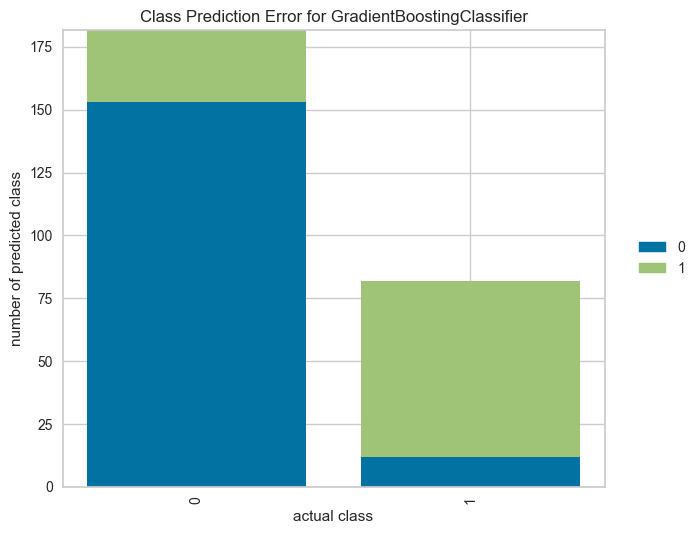

In [13]:
#Grafico erros
plot_model(tunned_model, plot='error')

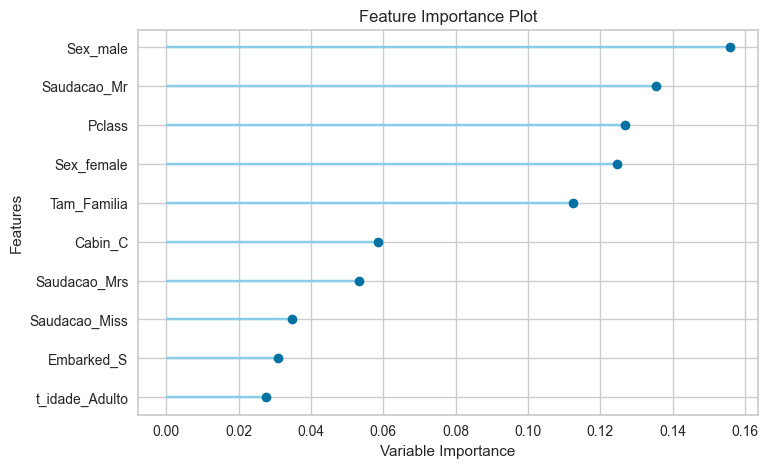

In [14]:
plot_model(tunned_model, plot='feature')

In [15]:
#Testando com dados de treinameto
p = predict_model(tunned_model)
p

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.8321,0.8722,0.6796,0.8537,0.7568,0.6311,0.6406


,Pclass,Tam_Familia,Saudacao_Master,Saudacao_Miss,Saudacao_Mr,Saudacao_Mrs,Saudacao_Other,Embarked_C,Embarked_Q,Embarked_S,...,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Survived,prediction_label,prediction_score
178,2,0,0,0,1,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0.8409
457,1,1,0,0,0,1,0,0,0,1,...,0,0,1,0,0,0,0,1,1,0.8694
16,3,5,1,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0.7402
95,3,0,0,0,1,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0.8349
120,2,2,0,0,1,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0.8732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
429,3,0,0,0,1,0,0,0,0,1,...,0,0,0,1,0,0,0,1,0,0.6642
615,2,3,0,1,0,0,0,0,0,1,...,0,1,0,0,0,0,0,1,1,0.7369
860,3,2,0,0,1,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0.8999
660,1,2,0,0,1,0,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0.8596


In [16]:
from sklearn import metrics as M

#Finalizar o modelo
final_model = finalize_model(tunned_model)
Survived_Predict = [1 if  i > 0.6 else 0 for i in p['prediction_label']]
print(M.accuracy_score(p['Survived'], Survived_Predict))

0.832089552238806


In [17]:
#Previsao
prev = predict_model(final_model, data=X_test)
prev

,Pclass,Tam_Familia,Saudacao_Master,Saudacao_Miss,Saudacao_Mr,Saudacao_Mrs,Saudacao_Other,Embarked_C,Embarked_Q,Embarked_S,...,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,prediction_label,prediction_score
0,3,0,0,0,1,0,0,0,1,0,...,0,0,1,0,0,0,0,False,0,0.8650
1,3,1,0,0,0,1,0,0,0,1,...,0,0,1,0,0,0,0,False,1,0.5143
2,2,0,0,0,1,0,0,0,1,0,...,0,0,1,0,0,0,0,False,0,0.8744
3,3,0,0,0,1,0,0,0,0,1,...,0,0,1,0,0,0,0,False,0,0.8367
4,3,2,0,0,0,1,0,0,0,1,...,0,0,1,0,0,0,0,False,0,0.5067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,3,0,0,0,1,0,0,0,0,1,...,0,0,1,0,0,0,0,False,0,0.8367
414,1,0,0,1,0,0,0,1,0,0,...,0,0,1,0,0,0,0,False,1,0.8501
415,3,0,0,0,1,0,0,0,0,1,...,0,0,1,0,0,0,0,False,0,0.8367
416,3,0,0,0,1,0,0,0,0,1,...,0,0,1,0,0,0,0,False,0,0.8367


In [18]:
Survived_Predict = [1 if  i > 0.6 else 0 for i in prev['prediction_label']]
df_pred = test.loc[:,['PassengerId']]
df_pred['Survived'] = Survived_Predict
df_pred.to_csv('predict_PYCARET.csv', index=False) 
df_pred

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
